# Avoiding Overfitting in Image Classification using PyTorch Lightening

_By: Harsh Kumar, Gojek_  
_13th July 20204_  

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
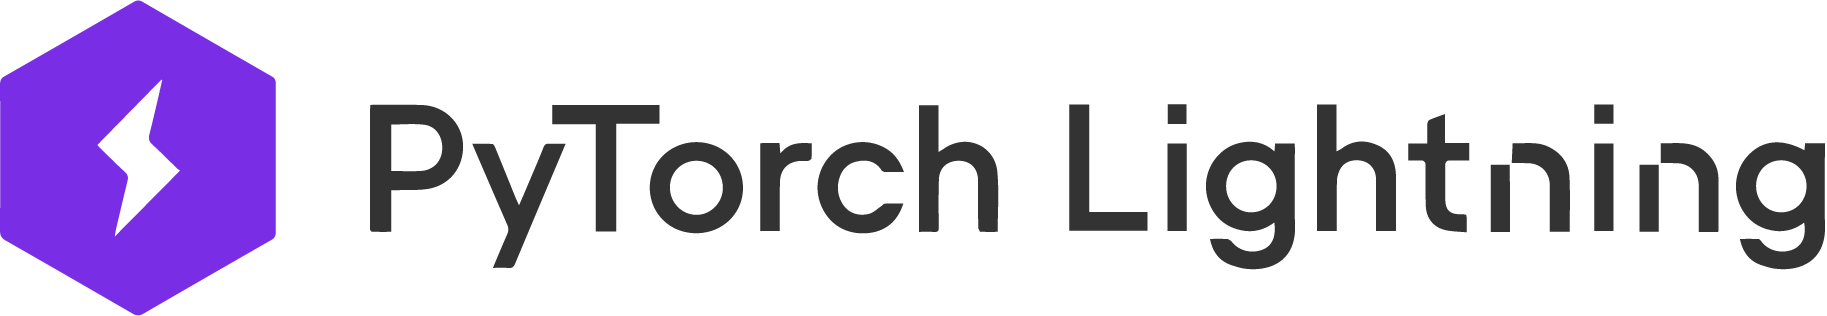

## Import libraries

In [1]:
import torch
import torchvision
import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.set_float32_matmul_precision('medium')
print(device)

cuda:0


## Get training and validation data

We will be using CIFAR10 dataset which has images of 10 categories

In [3]:
batch_size = 4

Define transformations of input images  
- Convert data to tensors  
- Normalize values

In [4]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     # Data Augmentation Transformations
     v2.RandomResizedCrop(size=(32, 32), antialias=True),
     v2.RandomHorizontalFlip(p=0.5)]
)

In [8]:
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

**NOTE:** Shuffle has been turned off for training dataset as well.  
In this notebook, we want to use the same subset of images to train the model in every epoch, so that overfitting is clearly detectable

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


**NOTE:** Since shuffle is turned off, we will get images in the same sequence from trainloader. We will restrict the number of training images to first 8000 (2000 batches of 4 images each). This will allow us to clearly show overfitting

In [10]:
subset_indices = list(range(8000))
trainsubset = torch.utils.data.Subset(trainset, subset_indices)
valsubset = torch.utils.data.Subset(valset, subset_indices)

In [11]:
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size, shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Name the classes which are part of the data

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

### Display sample images

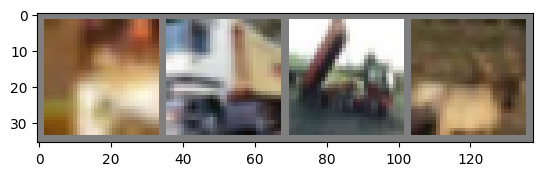

frog  truck truck deer 


In [13]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model structure

In [14]:
class ImgClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_loss_mean = []
        self.val_loss_mean = []
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
        return optimizer
        
    def cross_entropy_loss(self, y_pred, y):
        # return nn.CrossEntropyLoss()
        return F.nll_loss(y_pred, y)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x)
        loss = self.cross_entropy_loss(y_pred, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x)
        loss = self.cross_entropy_loss(y_pred, y)
        self.val_losses.append(loss)
        self.log('val_loss', loss)
        return loss

    def on_validation_epoch_end(self):
        avg_train_loss = np.nan
        if len(self.train_losses)>0:
            avg_train_loss = torch.stack(self.train_losses).mean()
        avg_val_loss = torch.stack(self.val_losses).mean()
        print(f'Epoch {self.current_epoch}: train_loss = {avg_train_loss:.4f} val_loss = {avg_val_loss:.4f}')

        self.train_loss_mean.append(avg_train_loss)
        self.val_loss_mean.append(avg_val_loss)
        self.train_losses.clear()
        self.val_losses.clear()

In [15]:
model = ImgClassifier()
model

ImgClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Train the Model

In [16]:
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,        # If True, prints a message when training is stopped early
    mode='min'           # Mode can be 'min' or 'max'
)

In [17]:
trainer = pl.Trainer(max_epochs=100 , enable_progress_bar=False, callbacks=[early_stop_callback])
trainer.fit(model, trainloader, valloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 456    | train
1 | pool    | MaxPool2d | 0      | train
2 | dropout | Dropout   | 0      | train
3 | conv2   | Conv2d    | 2.4 K  | train
4 | fc1     | Linear    | 48.1 K | train
5 | fc2     | Linear    | 10.2 K | train
6 | fc3     | Linear    | 850    | train
----------------------------------------------
62.0 K    Trainable params
0         Non-tra

Epoch 0: train_loss = nan val_loss = 2.3456


Metric val_loss improved. New best score: 2.289


Epoch 0: train_loss = 2.3014 val_loss = 2.2887


Metric val_loss improved by 0.256 >= min_delta = 0.0. New best score: 2.033


Epoch 1: train_loss = 2.1777 val_loss = 2.0326


Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.970


Epoch 2: train_loss = 2.0736 val_loss = 1.9698


Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.884


Epoch 3: train_loss = 2.0145 val_loss = 1.8841


Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.814


Epoch 4: train_loss = 1.9718 val_loss = 1.8141


Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.777


Epoch 5: train_loss = 1.9480 val_loss = 1.7768


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.765


Epoch 6: train_loss = 1.9259 val_loss = 1.7655


Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.744


Epoch 7: train_loss = 1.9077 val_loss = 1.7438


Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.683


Epoch 8: train_loss = 1.8881 val_loss = 1.6830
Epoch 9: train_loss = 1.8655 val_loss = 1.6837


Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.663


Epoch 10: train_loss = 1.8658 val_loss = 1.6629


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.659


Epoch 11: train_loss = 1.8609 val_loss = 1.6593
Epoch 12: train_loss = 1.8478 val_loss = 1.6775


Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.628


Epoch 13: train_loss = 1.8458 val_loss = 1.6276
Epoch 14: train_loss = 1.8454 val_loss = 1.6338
Epoch 15: train_loss = 1.8321 val_loss = 1.6339
Epoch 16: train_loss = 1.8296 val_loss = 1.6397
Epoch 17: train_loss = 1.8317 val_loss = 1.6778


Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.594


Epoch 18: train_loss = 1.8073 val_loss = 1.5942
Epoch 19: train_loss = 1.7993 val_loss = 1.6069
Epoch 20: train_loss = 1.8135 val_loss = 1.6036
Epoch 21: train_loss = 1.8055 val_loss = 1.6113


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.581


Epoch 22: train_loss = 1.7995 val_loss = 1.5814
Epoch 23: train_loss = 1.7905 val_loss = 1.5842
Epoch 24: train_loss = 1.8065 val_loss = 1.5932
Epoch 25: train_loss = 1.7848 val_loss = 1.6074


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.576


Epoch 26: train_loss = 1.7907 val_loss = 1.5760


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.561


Epoch 27: train_loss = 1.7856 val_loss = 1.5607
Epoch 28: train_loss = 1.7821 val_loss = 1.5718
Epoch 29: train_loss = 1.7826 val_loss = 1.5706


Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.539


Epoch 30: train_loss = 1.7717 val_loss = 1.5391
Epoch 31: train_loss = 1.7845 val_loss = 1.5930
Epoch 32: train_loss = 1.7722 val_loss = 1.5548
Epoch 33: train_loss = 1.7847 val_loss = 1.5692
Epoch 34: train_loss = 1.7826 val_loss = 1.5507


Monitored metric val_loss did not improve in the last 5 records. Best score: 1.539. Signaling Trainer to stop.


Epoch 35: train_loss = 1.7822 val_loss = 1.5571


### Plot Loss

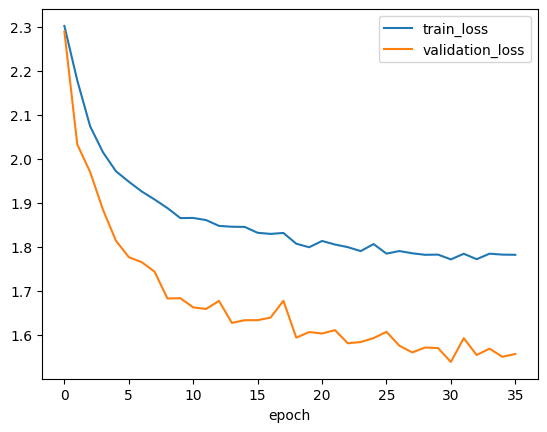

In [18]:
def plot_loss(train_loss_list, val_loss_list):
    train_loss_list = [i.item() for i in train_loss_list]
    val_loss_list = [i.item() for i in val_loss_list]
    
    df_loss = pd.DataFrame({"train_loss":train_loss_list, "validation_loss":val_loss_list})
    df_loss["epoch"] = df_loss.index
    
    axs = plt.subplot()
    df_loss.plot(x="epoch", y="train_loss", ax=axs)
    df_loss.plot(x="epoch", y="validation_loss", ax=axs)

plot_loss(model.train_loss_mean[1:], model.val_loss_mean[1:])

### Accuracy on Validation Data

In [19]:
def get_accuracy_val_data(model: ImgClassifier, valloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data_val in valloader:
            images, labels = data_val[0], data_val[1]
            # calculate outputs by running images through the network
            labels_pred = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(labels_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 41.69 %


### Tensorboard

We can see output on tensorboard.  
However, due to a bug the latest release is not working as expected. The bug has been fixed in nightly builds  
https://github.com/tensorflow/tensorboard/issues/6874

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

**NOTE**: Below is just the sample image to demonstrate how tensorboard output will look like  
Source: https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

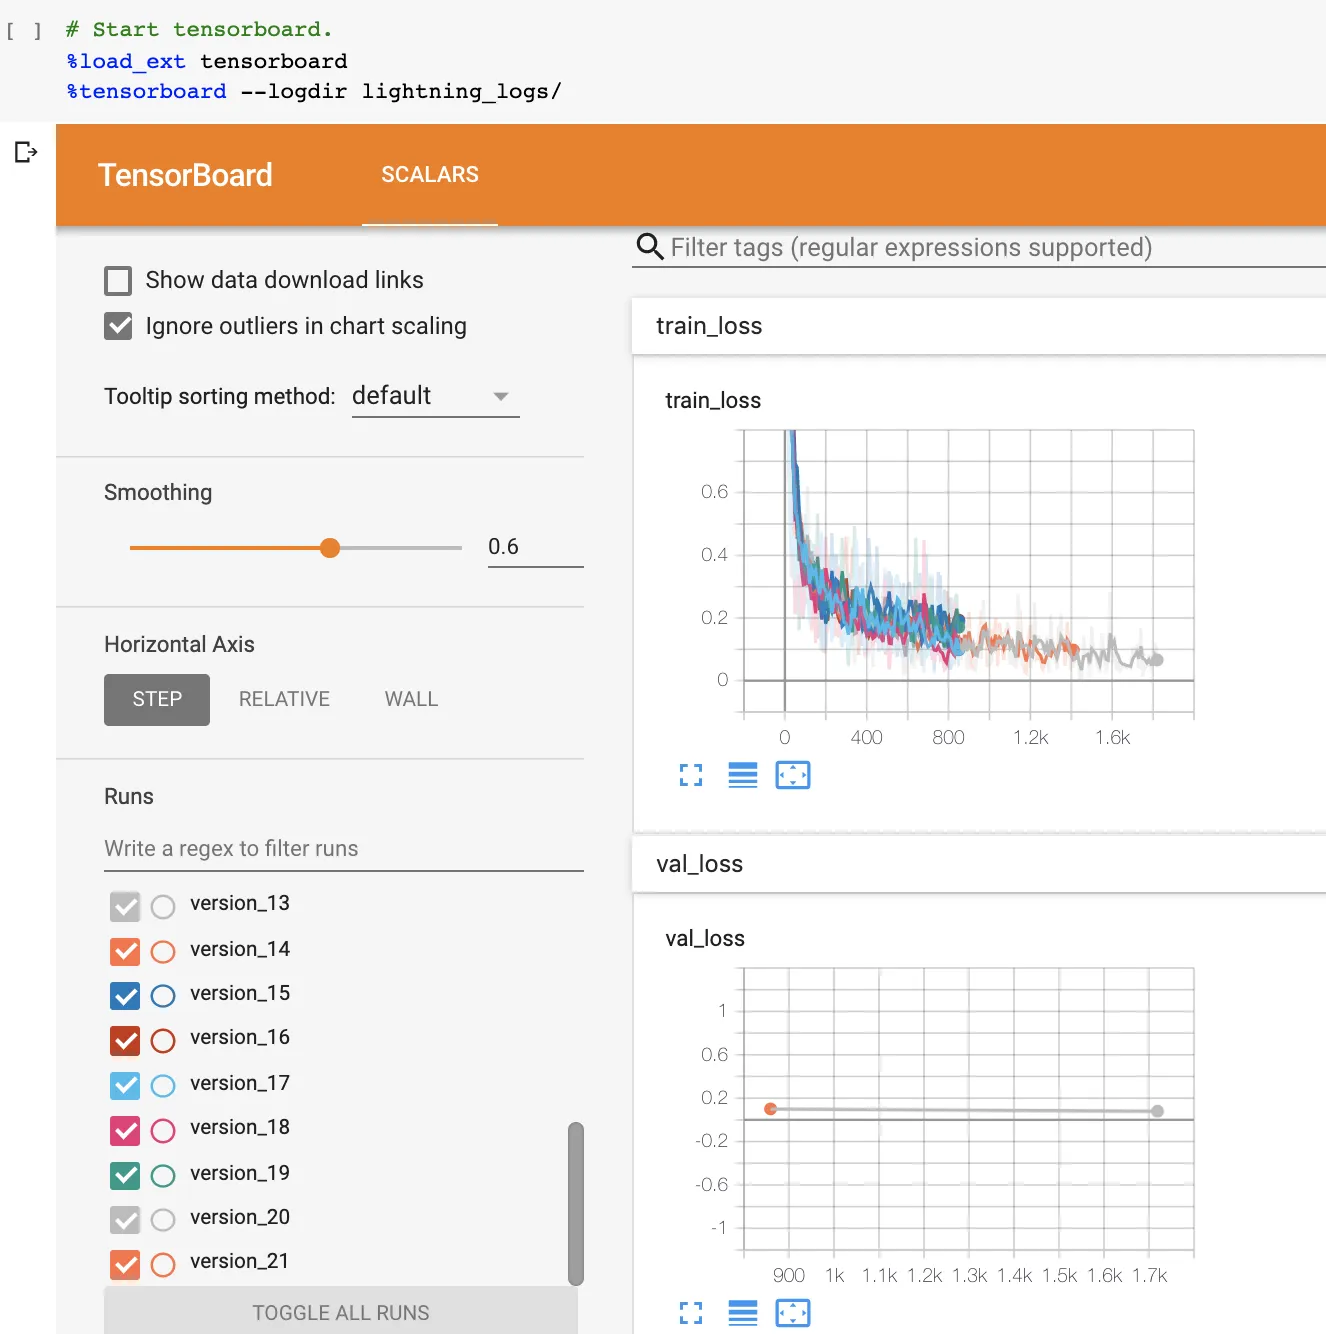